# $ARIMA(p,d,q)$ modeling of the CPI
This notebook goes through the process of constructing an autoregressive integrated moving average (ARIMA) model for the consumer price index. 

First, we import necessary packages

In [2]:
import pandas as pd # pandas for reading the data
from pandas.plotting import autocorrelation_plot # getting the autocorrelation plots 
from statsmodels.tsa.arima.model import ARIMA # creating the ARIMA model
from statsmodels.tsa.arima_model import ARMAResults  # for the ARIMA results after fitting
import numpy as np # for numerical work
import matplotlib.pyplot as plt # plotting the results  
import warnings # easier readability
import math # for computing the train test split 
warnings.filterwarnings("ignore")

## Train Test Split
As the classical time series technique we are applying here requires a complete dataset, the train test split will be done differently as compared to other models. We will use the first $70\%$ of the dataset for training the model, and then test the dataset on the more recent, remaining $30\%$ of the data. Since the dataset begins in 1993, this will test the dataset on about nine years of monthly data (107 datapoints).

In [4]:
df = pd.read_csv('ALL_DATA_Marc93.csv') # read the dataframe 
cpi = df['CPI'] # pull only the CPI
X_train = cpi[:math.ceil(len(cpi) * .7)] # create the training set 
X_test = cpi[math.ceil(len(cpi) * .7):] # create the testing set 
print(X_train)# display the training set 
print(X_test) # display the testing set 

0      143.300
1      143.800
2      144.200
3      144.300
4      144.500
        ...   
246    233.544
247    233.669
248    234.100
249    234.719
250    235.288
Name: CPI, Length: 251, dtype: float64
251    235.547
252    236.028
253    236.468
254    236.918
255    237.231
        ...   
353    295.620
354    296.761
355    298.062
356    298.349
357    298.112
Name: CPI, Length: 107, dtype: float64


The first item of business for an ARIMA is to determine how many finite differences are needed for modeling. This represents in the "integrated" piece of ARIMA. The goal is to have the autocorrelation plots quickly go to $0$ and hover around this value.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

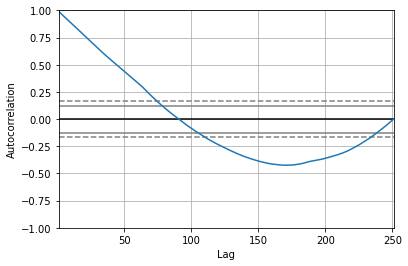

In [3]:
autocorrelation_plot(X_train) # create an autocorrelation using 0 differences

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

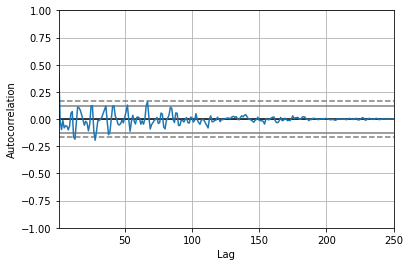

In [4]:
autocorrelation_plot(np.diff(X_train)) # creating an autocorrelation plot with 1 difference 

One difference was enough, so we set `d = 1` in $ARIMA(p,d,q)$. Now, we need to test how many memory and average terms we need. This is typically done by testing $0,1,$ or $2$ memory terms (this is $p$) and average terms (this is $q$). We verify which is the best used the Akaike Information Criteria (AIC) and Bayes Information Criteria (BIC). These are information theoretic terms that tells how "simple" this model is. The goal is to use a model of a low AIC and BIC values. 

In [5]:
# 1 diff was needed so d = 1 for ARIMA (p, d, q)
d = 1
for p in range(3): # iterate on p values
    for q in range(3): # iterate on q values 
        print('p = ', p, '| q = ', q)
        model = ARIMA(X_train, order=(p,d,q)) # create a model with these parameters
        results_ARIMA = model.fit() # train a model
        print('aic = ', results_ARIMA.aic)
        print('bic = ', results_ARIMA.bic)
        print('==================NEXT MODEL==================')


p =  0 | q =  0
aic =  510.1442284005786
bic =  513.6656893184409
==================NEXT MODEL==================
p =  0 | q =  1
aic =  418.7914146142671
bic =  425.8343364499916
==================NEXT MODEL==================
p =  0 | q =  2
aic =  401.24887440225837
bic =  411.8132571558451
==================NEXT MODEL==================
p =  1 | q =  0
aic =  403.1620563713611
bic =  410.20497820708556
==================NEXT MODEL==================
p =  1 | q =  1
aic =  401.09885445702355
bic =  411.6632372106103
==================NEXT MODEL==================
p =  1 | q =  2
aic =  373.35276526917244
bic =  387.4386089406214
==================NEXT MODEL==================
p =  2 | q =  0
aic =  402.5297096439082
bic =  413.09409239749493
==================NEXT MODEL==================
p =  2 | q =  1
aic =  402.94870425329725
bic =  417.0345479247462
==================NEXT MODEL==================
p =  2 | q =  2
aic =  373.279111869253
bic =  390.8864164585642
==================NEXT MO

We see that the lowest aic and bcs are from $p = 1$ and $q = 2$. Therefore, we use an $ARIMA(1,1,2)$ model. Thus, we create this model below, train it, and review the results.

In [16]:
p = 1 
q = 2
model = ARIMA(X_train, order=(p,d,q))
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  251
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -182.676
Date:                Wed, 15 Feb 2023   AIC                            373.353
Time:                        11:58:11   BIC                            387.439
Sample:                             0   HQIC                           379.022
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2084.913      0.000       0.999       1.001
ma.L1         -0.5340      0.128     -4.158      0.000      -0.786      -0.282
ma.L2         -0.4647      0.071     -6.571      0.0

Here, we compute the mean square error (MSE) of the $ARIMA(1,1,2)$ model on the testing data.

In [6]:
print('MSE = ', np.mean((results_ARIMA.forecast(math.ceil(len(cpi) * .3)) - X_test) ** 2))

MSE =  68.06098028899179


Below, we plot the testing portion of our resulting model. 

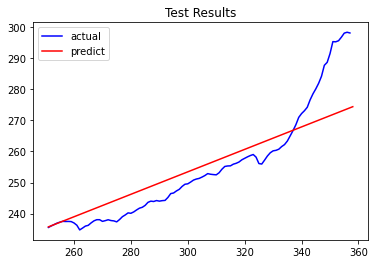

In [15]:
plt.plot(cpi[math.ceil(len(cpi) * .7):], color = 'blue', label = 'actual') 
plt.plot(results_ARIMA.forecast(math.ceil(len(cpi) * .3)), color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()

Below, we plot the training results.

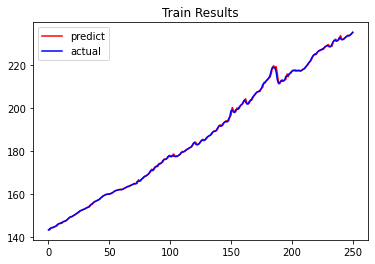

In [16]:
plt.plot(results_ARIMA.fittedvalues[1:], color = 'red', label = 'predict') # the first item is 0 as the time series is not infinite
plt.plot(cpi[:math.ceil(len(cpi) * .7)], color = 'blue', label = 'actual') 
plt.legend()
plt.title('Train Results')
plt.show()

This model was much more accurate on the training set than the testing set. The model was not able to predict extreme inflation striking to quite the level it did, and instead was predicting nearly linear growth.